# Produccion eléctrica en base a la metereología

La idea principal del trabajo es ser capaces de predecir como va a afectar a la produccion eléctrica de energias renovables y no renovables las precipitaciones, el viento y las horas de sol.
Como las horas de sol y el viento son fenomenos cuya causa efecto en principio es prácticamente inmediato, también vamos a centrarnos en la produccion de energia hidroelectrica para poder medir cuanto tiempo tarda en afectar a este tipo de energía las precipitaciones..

En base a esto tenemos varias cuestiones que queremos despejar:
- Que relación hay entre precipitaciones y el aumento de la generación de energia eléctrica hidráulica.
- Que relación hay entre horas de sol, temperatura y el aumento de la generación de energia eléctrica sólar.
- Que relación hay entre viento y el aumento de la generación de energia eléctrica eólica, esta relación esta condicionada por la temperatura, percipitaciones o horas de sol.
- Cuantos días tarda en aumentar la generación eléctrica de fuentes de energía renovables en función de los fenomenos metereológicos.
- Dados una prediccion meteorologica que valores de generación eléctrica tendremos para una fecha determinada.



Como premisas partimos de :
- Vamos a considerar solo el poll de energia que proporciona Red Electrica de España (REE)
- Vamos a considerar que las empresas no trabajan bajo mala praxis y que intentan optimizar el uso de energias renovables.
- Debido a la falta de datos a nivel diario de REE por provincia o comunidades autonomas, voy a centrar el analisis a nivel de sistema eléctrico (Peninsula, Baleares, Canarias ,Ceuta y Melilla).

Como origenes de datos para el estudio vamos a utilizar los datos proporcionados por:
- Información de REE (https://www.ree.es/es/apidatos) obtenida mediante su API.
- Datos proporcionados por aemet(https://opendata.aemet.es/centrodedescargas/inicio), vamos a utilizar la libreria  aemet desarrollada por Pablo Moreno (https://pypi.org/project/python-aemet/).

Requisitos para la ejecución del notebook:

Como requisitos para la ejecución del proyecto es necesario la instalación de la libreria python Aemet(pip install python-aemet) e instalar la libreria request.

Además las versiones de cada libreria utilizada en este proyecto son:

El modelo ha utilizar al tratarse de una prediccion númerica y no de obtener una etiqueta, sera una regresión.
Para poder llevar a cabo esa regresion se han pasado los valores de fechas a númericos, y se ha creado una columna por cada tipo de energia, creando varias variables objetivo.



In [61]:
# If the code is executed from Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/TFM_Generacion_electrica_AEMET/Python

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/TFM_Generacion_electrica_AEMET/Python'
/content/drive/My Drive/TFM_Generacion_electrica_AEMET/Python


In [62]:
# Instalacion libreria AEMET para ingesta de datos
!pip install python-aemet

In [87]:
from Lectura_AEMET_REE import Ingestion_AEMET,Ingestion_REE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

Ing_AEMET=Ingestion_AEMET()

Ing_REE=Ingestion_REE()

pd.options.display.max_columns=None
plt.style.use('ggplot')



In [4]:
# put this in an input sentence
date_ini="2016-01-01T00:00:00UTC"
date_end="2021-12-31T00:00:00UTC"

# 1- Read data from API and CSV

###  Lectura datos AEMET <a id='From_api'></a>

Para la lectura de datos metereólogicos, vamos a utilizar la libreria aemet, de la que utilizaremos los metodos de las clases Aemet y Estacion para obtener los datos a nivel diario de cada estación meterologica para un rago de fechas, de las provincias que nos interesan para el estudio.<a id='From_api'></a>

In [5]:
df_weather=Ing_AEMET.read_weather_dates(date_ini,date_end)

Reading list of id of weather stations...



Reading AEMET data from 2016-01-01T00:00:00UTC to 2016-12-31T00:00:00UTC ...



Reading AEMET data from 2017-01-01T00:00:00UTC to 2017-12-31T00:00:00UTC ...



Reading AEMET data from 2018-01-01T00:00:00UTC to 2018-12-31T00:00:00UTC ...



Reading AEMET data from 2019-01-01T00:00:00UTC to 2019-12-31T00:00:00UTC ...



Reading AEMET data from 2020-01-01T00:00:00UTC to 2020-12-31T00:00:00UTC ...



Reading AEMET data from 2021-01-01T00:00:00UTC to 2021-12-31T00:00:00UTC ...


Valor no encontrado

Finish reading AEMET date from 2016-01-01 to 2021-05-21


### Lectura de los datos de REE

Para la lectura de los datos de REE voy a utilizar la libreria python requests para a traves de su API, obtener la generación de electricidad en , para cada tipo de energia Electrica.

Una vez leidos los datos de la API, guardo los datos en formato json en un fichero. para no tener que repetir las consultas y poder trabajar sin conexion.

La estrutura de los datos leidos de REE es la siguiente:


Por lo que vamos a almacenar 2 ficheros:
    - Renovables
    - No Renovables



In [6]:
df_ree=Ing_REE.read_ree_dates(date_ini,date_end)

## Other data

https://datos.gob.es/en/catalogo/l01280796-calendario-laboral

In [7]:
df_holidays=pd.read_csv(Ing_AEMET.path_Data+'calendario.csv',
                        sep=';',
                        encoding = 'latin-1',
                        usecols=['Dia','Tipo de Festivo'],
                        dtype=str)
df_holidays['Holiday']=(df_holidays['Tipo de Festivo']=='Festivo nacional').astype(np.int)
df_holidays['Dia']=pd.to_datetime(df_holidays['Dia'])

df_holidays.drop(columns='Tipo de Festivo',inplace=True)
df_holidays.dropna(inplace=True)

In [8]:
df_weather['fecha']=pd.to_datetime(df_weather['fecha'])
df_weather=df_weather.merge(df_holidays,how='left',left_on='fecha',right_on='Dia')
df_weather['weekday']=df_weather['Dia'].dt.dayofweek
df_weather.drop(columns='Dia',inplace=True)

In [9]:
df_weather.head()

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin,Holiday,weekday
0,2016-01-01,0252D,ARENYS DE MAR,BARCELONA,74,"11,2","0,2","7,8",06:20,"14,7",12:40,24,"1,7","7,2",14:00,NaN,NaN,NaN,NaN,NaN,1,4
1,2016-01-02,0252D,ARENYS DE MAR,BARCELONA,74,"11,8","0,0","7,5",23:40,"16,1",13:10,24,"1,1","9,7",11:40,NaN,NaN,NaN,NaN,NaN,0,5
2,2016-01-03,0252D,ARENYS DE MAR,BARCELONA,74,"10,0","0,0","5,8",05:50,"14,1",13:20,24,"1,9","9,2",16:00,NaN,NaN,NaN,NaN,NaN,0,6
3,2016-01-04,0252D,ARENYS DE MAR,BARCELONA,74,"11,6","0,9","8,0",22:50,"15,3",10:10,32,"0,8","8,9",02:40,NaN,NaN,NaN,NaN,NaN,0,0
4,2016-01-05,0252D,ARENYS DE MAR,BARCELONA,74,"9,9","0,1","5,6",23:59,"14,2",12:30,32,"2,5","8,6",17:30,NaN,NaN,NaN,NaN,NaN,1,1


## Saving Data to CSV

Para evitar tener que leer todos los datos en cada ejecucion, guardamos los en formato csv desde los DataFrame de REE y AEMET

In [10]:
Ing_AEMET.save_to_csv(df_weather)

Ing_REE.save_to_csv(df_ree) 

# 2- Cleaning data <a id='From_csv'></a>

In [93]:
df_weather=Ing_AEMET.read_from_csv()
df_ree=Ing_REE.read_from_csv()

In [94]:
df_ree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80498 entries, 0 to 703
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   value       80497 non-null  object
 1   percentage  80498 non-null  object
 2   datetime    80498 non-null  object
 3   title       80498 non-null  object
 4   type        80498 non-null  object
 5   system      80498 non-null  object
dtypes: object(6)
memory usage: 4.3+ MB


In [95]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487058 entries, 0 to 487057
Data columns (total 22 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   fecha        487058 non-null  object
 1   indicativo   487058 non-null  object
 2   nombre       487058 non-null  object
 3   provincia    487058 non-null  object
 4   altitud      487058 non-null  object
 5   tmed         473786 non-null  object
 6   prec         472859 non-null  object
 7   tmin         473828 non-null  object
 8   horatmin     466856 non-null  object
 9   tmax         473929 non-null  object
 10  horatmax     467241 non-null  object
 11  dir          452471 non-null  object
 12  velmedia     455475 non-null  object
 13  racha        452477 non-null  object
 14  horaracha    452454 non-null  object
 15  sol          270246 non-null  object
 16  presMax      363400 non-null  object
 17  horaPresMax  363392 non-null  object
 18  presMin      363405 non-null  object
 19  ho

## Limpieza datos AEMET


In [96]:
def limpieza(df,cols):
    for element in cols:
        df[element]=df[element].str.replace(',', '.')
        df[element]=pd.to_numeric(df[element],errors='coerce')
    return df

# Elimino las columnas que no me interesan
df_weather.drop(columns=['altitud','horaPresMax','horaPresMin','horaracha','dir','horatmin','horatmax'],inplace=True)

df_weather=limpieza(df_weather,df_weather.columns[4:13])
df_weather

,fecha,indicativo,nombre,provincia,tmed,prec,tmin,tmax,velmedia,racha,sol,presMax,presMin,Holiday,weekday
0,2016-01-01,0252D,ARENYS DE MAR,BARCELONA,11.2,0.2,7.8,14.7,1.7,7.2,NaN,NaN,NaN,1,4
1,2016-01-02,0252D,ARENYS DE MAR,BARCELONA,11.8,0.0,7.5,16.1,1.1,9.7,NaN,NaN,NaN,0,5
2,2016-01-03,0252D,ARENYS DE MAR,BARCELONA,10.0,0.0,5.8,14.1,1.9,9.2,NaN,NaN,NaN,0,6
3,2016-01-04,0252D,ARENYS DE MAR,BARCELONA,11.6,0.9,8.0,15.3,0.8,8.9,NaN,NaN,NaN,0,0
4,2016-01-05,0252D,ARENYS DE MAR,BARCELONA,9.9,0.1,5.6,14.2,2.5,8.6,NaN,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487053,2021-05-17,C429I,TENERIFE SUR AEROPUERTO,STA. CRUZ DE TENERIFE,22.4,0.0,19.2,25.5,7.5,17.5,6.7,1010.8,1007.6,0,0
487054,2021-05-18,C429I,TENERIFE SUR AEROPUERTO,STA. CRUZ DE TENERIFE,23.6,0.0,18.9,28.4,10.3,20.0,6.0,1011.6,1008.8,0,1
487055,2021-05-19,C429I,TENERIFE SUR AEROPUERTO,STA. CRUZ DE TENERIFE,23.8,0.0,17.0,30.5,7.5,18.9,12.1,1011.0,1007.3,0,2
487056,2021-05-20,C429I,TENERIFE SUR AEROPUERTO,STA. CRUZ DE TENERIFE,23.8,0.0,18.0,29.7,3.9,19.7,12.6,1008.8,1005.8,0,3


In [97]:
''' Creo una funcion que pase los indicadores a float 
y rellene los valores vacios por la media de las estaciones de esa provincia para ese dia'''

def rellena_nulos_provincia(df,cols_max,cols_min,cols_mean):
    
    # Gropued by provincia and fecha
    df_mean=df.groupby(['provincia','fecha','Holiday','weekday'],as_index=False)[cols_mean].mean()
    df_max=df.groupby(['provincia','fecha','Holiday','weekday'],as_index=False)[cols_max].max()
    df_min=df.groupby(['provincia','fecha','Holiday','weekday'],as_index=False)[cols_min].min()   
    # Union of the 3 datasets by provincia and fecha
    df_group=pd.merge(df_mean,df_max, how='inner', on=['provincia','fecha','Holiday','weekday'])
    df_all=pd.merge(df_min,df_group, how='inner', on=['provincia','fecha','Holiday','weekday'])

    return df_all

df_weather_group=rellena_nulos_provincia(df_weather,['tmax','presMax','racha'],['tmin','presMin'],['prec','tmed','sol','velmedia'])

In [98]:
electric_systems={
    'STA. CRUZ DE TENERIFE':'canarias',
    'LAS PALMAS':'canarias',
    'ILLES BALEARS':'baleares',
    'CEUTA':'ceuta',
    'MELILLA':'melilla'}

# Now each provincia have the same weigth in the DataFrame, we need to agrup by electric system to join the data after.

df_weather_group['system']=[electric_systems[l.upper()]  
                      if l.upper() in electric_systems.keys() else 'peninsular' 
                      for l in df_weather_group['provincia'] ]

weather_grouped=df_weather_group.groupby(['fecha','system','Holiday','weekday'],as_index=False)
df_weather_system=weather_grouped.mean(['tmed','prec','tmin','tmax','velmedia','sol','presMax','presMin','racha'])
df_weather_system.fillna(0,inplace=True)
df_weather_system.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9840 entries, 0 to 9839
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fecha     9840 non-null   object 
 1   system    9840 non-null   object 
 2   Holiday   9840 non-null   object 
 3   weekday   9840 non-null   object 
 4   tmin      9840 non-null   float64
 5   presMin   9840 non-null   float64
 6   prec      9840 non-null   float64
 7   tmed      9840 non-null   float64
 8   sol       9840 non-null   float64
 9   velmedia  9840 non-null   float64
 10  tmax      9840 non-null   float64
 11  presMax   9840 non-null   float64
 12  racha     9840 non-null   float64
dtypes: float64(9), object(4)
memory usage: 1.1+ MB


## Limpieza de datos de REE

In [99]:
Renovable_system=pd.unique(df_ree[df_ree['type']=='Renovable']['system'])
df_ree_renov=df_ree[df_ree['system'].isin(Renovable_system)]

In [100]:
df_ree_renov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76410 entries, 0 to 703
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   value       76409 non-null  object
 1   percentage  76410 non-null  object
 2   datetime    76410 non-null  object
 3   title       76410 non-null  object
 4   type        76410 non-null  object
 5   system      76410 non-null  object
dtypes: object(6)
memory usage: 4.1+ MB


In [101]:
# Renombro los campos
df_ree_renov.rename(columns={'value':'Generacion_Mwh','title':'Tecnologia','type':'Renov_norenov'},inplace=True)

# Elimino la columna percentage por ser una columna generada de Generacion_Mwh.
df_ree_renov.drop(columns=['percentage'],inplace=True)

# Cambio los valores nulos de Generacion en Mwh por 0
df_ree_renov['Generacion_Mwh']=df_ree_renov['Generacion_Mwh'].fillna(0).astype(float)

# Elimino las filas para las cuales la fecha es nula y paso la fecha a formato corto.
df_ree_renov['fecha']=df_ree_renov['datetime'].str[:10]
df_ree_renov=df_ree_renov[~df_ree_renov['fecha'].isna()]
df_ree_renov.drop(columns=['datetime'],inplace=True)
df_ree_renov.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/py

,Generacion_Mwh,Tecnologia,Renov_norenov,system,fecha
0,29281.000,Hidráulica,Renovable,peninsular,2016-01-01
1,35544.881,Hidráulica,Renovable,peninsular,2016-01-02
2,35910.705,Hidráulica,Renovable,peninsular,2016-01-03
3,65268.886,Hidráulica,Renovable,peninsular,2016-01-04
4,79718.832,Hidráulica,Renovable,peninsular,2016-01-05


# Electric generation features analysis

## Total Generation

In [102]:
def plot_generacion(df,tech,system,fecini_zoom,fecfin_zoom,c='r'):
 
  f,ax=plt.subplots(1,1)
  f.set_size_inches(18,6)
  f.suptitle('Evolución de la generacion (Mwh) por fecha', fontsize=20)
 
  filter1=(df['Tecnologia'].isin(tech)) & (df['system']==system)
  ax.plot(df[filter1]['fecha'],df[filter1]['Generacion_Mwh'],c,alpha=0.6)
  ax.set_xticklabels([])
  ax.set_title(system.upper(),fontsize=14)
  ax.set_xlabel('Fecha')
  ax.set_ylabel('Mwh')
    
  title_zoom='Zoom: from '+fecini_zoom+' to '+ fecfin_zoom
  filter2=filter1 & (df['fecha']>=fecini_zoom) & (df['fecha']<=fecfin_zoom)
  ax_zoom=f.add_axes([.63,.13,.25,.2])
  ax_zoom.plot(df[filter2]['fecha'],df[filter2]['Generacion_Mwh'],c,alpha=0.6)
  ax_zoom.set_xticklabels([])
  ax_zoom.set_title(title_zoom,fontsize=12)
  ax_zoom.set_ylabel('Mwh')
 
  return None

      Generacion_Mwh        Tecnologia     Renov_norenov      system  \
4398      537090.081  Generación total  Generación total  peninsular   
4399      619096.702  Generación total  Generación total  peninsular   
4400      663175.263  Generación total  Generación total  peninsular   
4401      670891.594  Generación total  Generación total  peninsular   
4402      712002.286  Generación total  Generación total  peninsular   
...              ...               ...               ...         ...   
1867      611606.400  Generación total  Generación total  peninsular   
1868      621816.800  Generación total  Generación total  peninsular   
1869      564188.000  Generación total  Generación total  peninsular   
1870      520766.200  Generación total  Generación total  peninsular   
1871      609769.600  Generación total  Generación total  peninsular   

           fecha  
4398  2016-01-01  
4399  2016-01-02  
4400  2016-01-03  
4401  2016-01-04  
4402  2016-01-05  
...          ...  
18

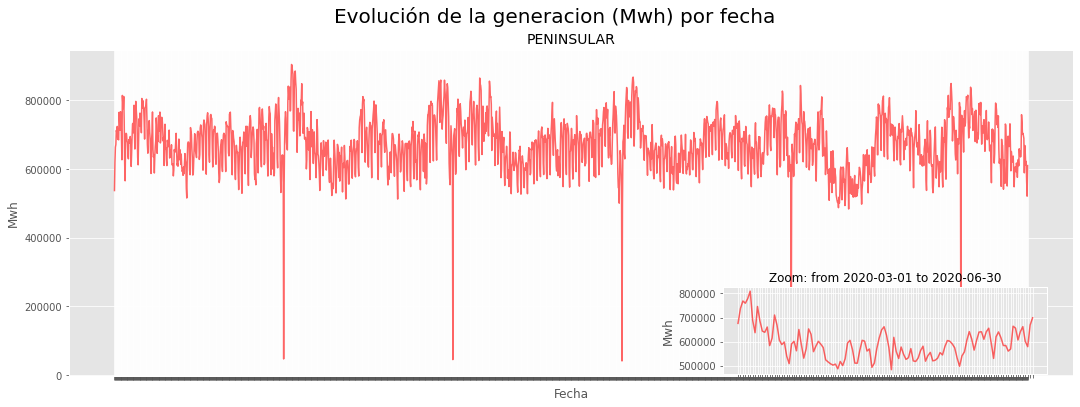

In [103]:
plot_generacion(df_ree_renov,['Generación total'],'peninsular','2020-03-01','2020-06-30')

      Generacion_Mwh        Tecnologia     Renov_norenov    system       fecha
3294       20220.015  Generación total  Generación total  canarias  2016-01-01
3295       22942.014  Generación total  Generación total  canarias  2016-01-02
3296       22186.025  Generación total  Generación total  canarias  2016-01-03
3297       24194.690  Generación total  Generación total  canarias  2016-01-04
3298       24182.306  Generación total  Generación total  canarias  2016-01-05
...              ...               ...               ...       ...         ...
1387       21978.806  Generación total  Generación total  canarias  2021-05-20
1388       22126.169  Generación total  Generación total  canarias  2021-05-21
1389       20718.418  Generación total  Generación total  canarias  2021-05-22
1390       19118.786  Generación total  Generación total  canarias  2021-05-23
1391       21838.205  Generación total  Generación total  canarias  2021-05-24

[1971 rows x 5 columns]


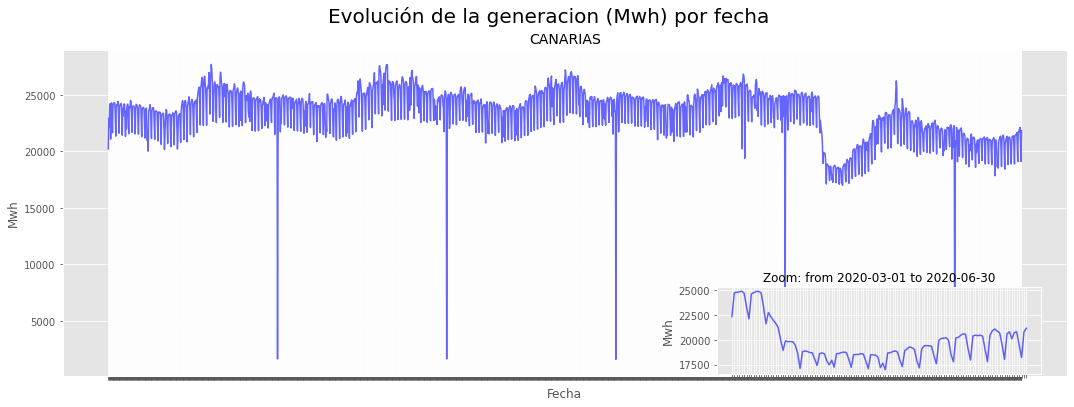

In [104]:
plot_generacion(df_ree_renov,['Generación total'],'canarias','2020-03-01','2020-06-30',c='b')

      Generacion_Mwh        Tecnologia     Renov_norenov    system       fecha
3640        8814.678  Generación total  Generación total  baleares  2016-01-01
3641        9435.611  Generación total  Generación total  baleares  2016-01-02
3642        9497.967  Generación total  Generación total  baleares  2016-01-03
3643       10236.225  Generación total  Generación total  baleares  2016-01-04
3644       10213.430  Generación total  Generación total  baleares  2016-01-05
...              ...               ...               ...       ...         ...
1544        9053.040  Generación total  Generación total  baleares  2021-05-20
1545        8964.683  Generación total  Generación total  baleares  2021-05-21
1546        8624.476  Generación total  Generación total  baleares  2021-05-22
1547        8699.111  Generación total  Generación total  baleares  2021-05-23
1548        8906.756  Generación total  Generación total  baleares  2021-05-24

[1971 rows x 5 columns]


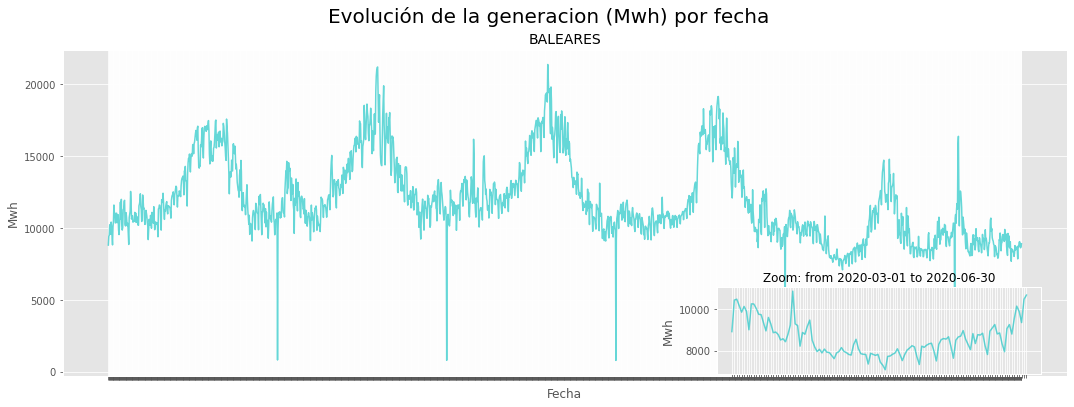

In [105]:
plot_generacion(df_ree_renov,['Generación total'],'baleares','2020-03-01','2020-06-30',c='c')

      Generacion_Mwh        Tecnologia     Renov_norenov   system       fecha
1425         479.011  Generación total  Generación total  melilla  2016-01-01
1426         520.350  Generación total  Generación total  melilla  2016-01-02
1427         505.428  Generación total  Generación total  melilla  2016-01-03
1428         539.698  Generación total  Generación total  melilla  2016-01-04
1429         564.941  Generación total  Generación total  melilla  2016-01-05
...              ...               ...               ...      ...         ...
699          557.043  Generación total  Generación total  melilla  2021-05-20
700          551.525  Generación total  Generación total  melilla  2021-05-21
701          539.367  Generación total  Generación total  melilla  2021-05-22
702          505.571  Generación total  Generación total  melilla  2021-05-23
703          554.210  Generación total  Generación total  melilla  2021-05-24

[1971 rows x 5 columns]


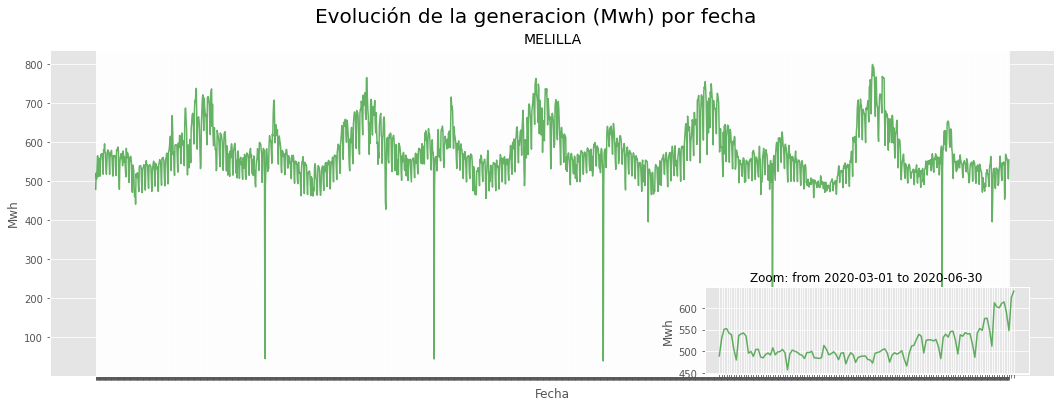

In [106]:
plot_generacion(df_ree_renov,['Generación total'],'melilla','2020-03-01','2020-06-30',c='g')

In [107]:
df_ree_filtered=df_ree_renov[(df_ree_renov['fecha']<'2020-03-15') | (df_ree_renov['fecha']>='2020-06-28')]

# Weather features analysis

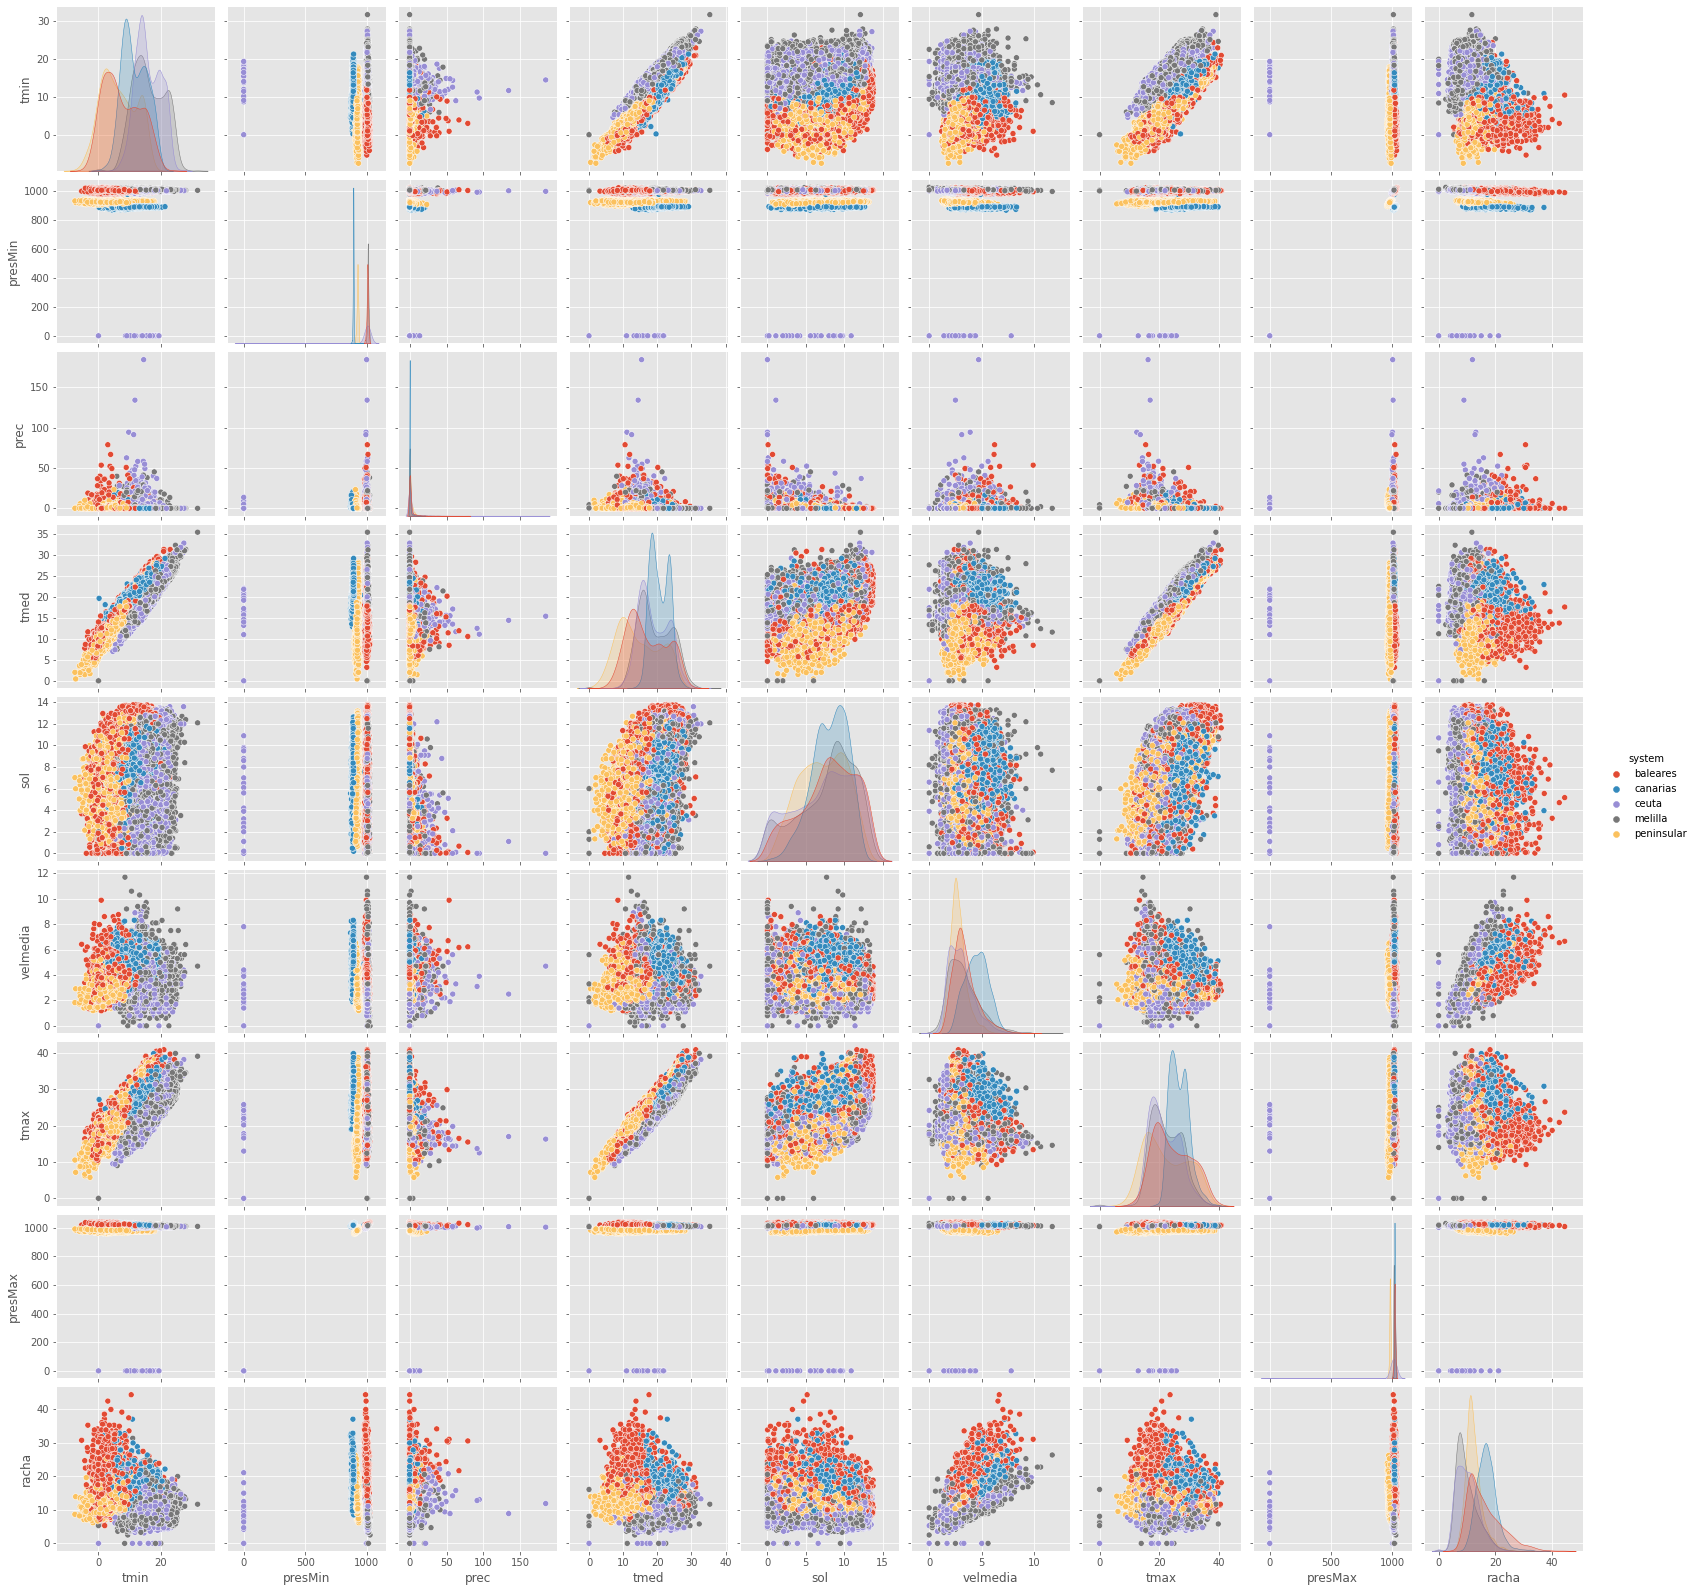

In [109]:
sns.pairplot(data=df_weather_system,hue='system')

Vemos que en funcion de la presion (minima y maxima):
    - Hay 2 grupos muy claramente diferenciandos para temperaturas , velocidad del viento y horas de sol.
    - Y 2 grupos pero no tan claramente diferenciados para las precipitaciones
    - Se ve claramente un dato outlier para precipitaciones y otro para temperatura minima

## Precipitacions

In [110]:
df_weather_system['prec'].describe()

count    9840.000000
mean        1.344007
std         4.987781
min         0.000000
25%         0.000000
50%         0.000000
75%         0.469761
max       184.400000
Name: prec, dtype: float64

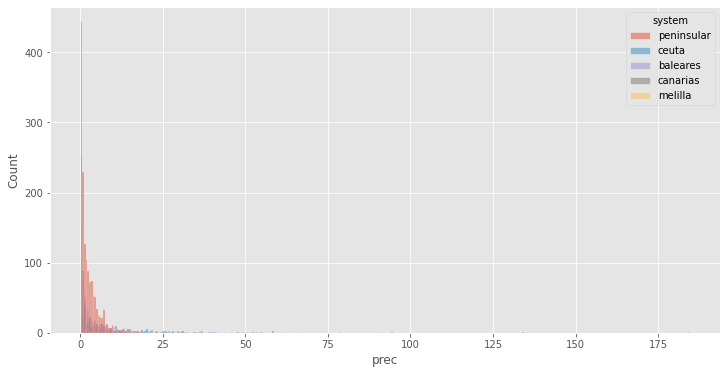

In [111]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.histplot(data=df_weather_system[df_weather_system['prec']>0.1],x='prec',hue='system',alpha=0.5);

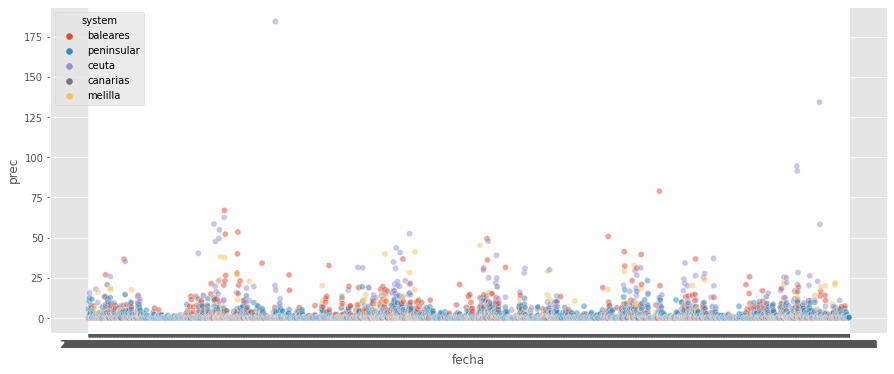

In [112]:
f,ax=plt.subplots(1,1)
f.set_size_inches(15,6)
ax=sns.scatterplot(data=df_weather_system[df_weather_system['prec']>0],y='prec',x='fecha',hue='system',alpha=0.5);

## Hours of sun

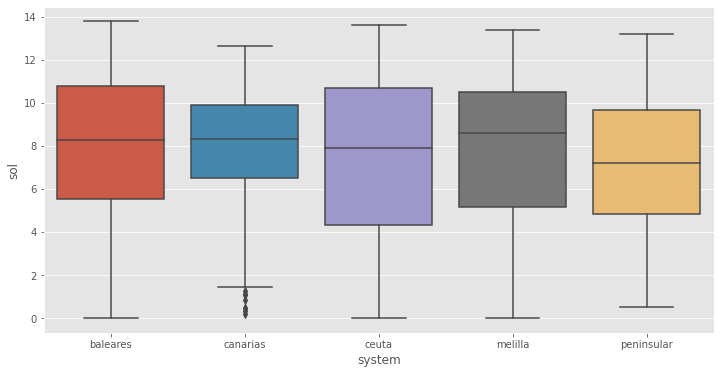

In [113]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='sol', data=df_weather_system);

In [114]:
df_weather_system['sol'].describe()

count    9840.000000
mean        7.639289
std         3.365453
min         0.000000
25%         5.397372
50%         8.100000
75%        10.219840
max        13.783333
Name: sol, dtype: float64

## Temperature

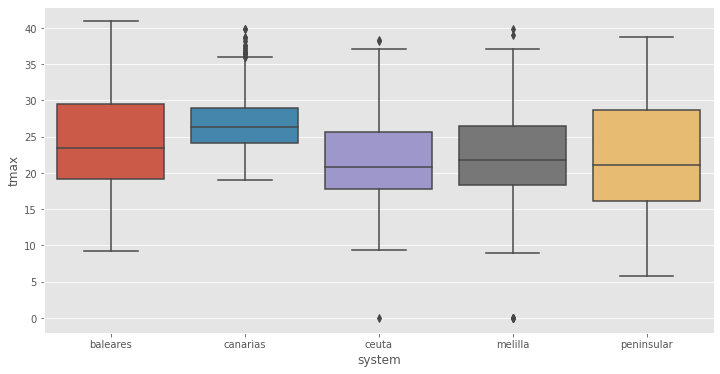

In [115]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='tmax', data=df_weather_system);

In [116]:
df_weather_system['tmax'].describe()

count    9840.000000
mean       23.545727
std         5.879631
min         0.000000
25%        18.800000
50%        23.600000
75%        27.900000
max        40.900000
Name: tmax, dtype: float64

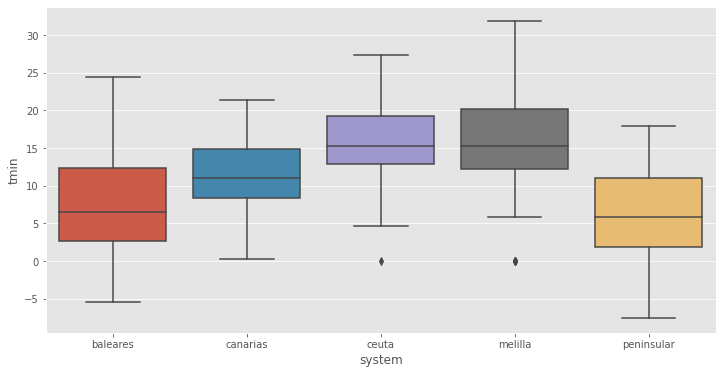

In [117]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='tmin', data=df_weather_system);

In [118]:
df_weather_system['tmin'].describe()

count    9840.000000
mean       11.457611
std         6.371999
min        -7.570213
25%         7.150000
50%        12.000000
75%        15.750000
max        31.800000
Name: tmin, dtype: float64

## Wind

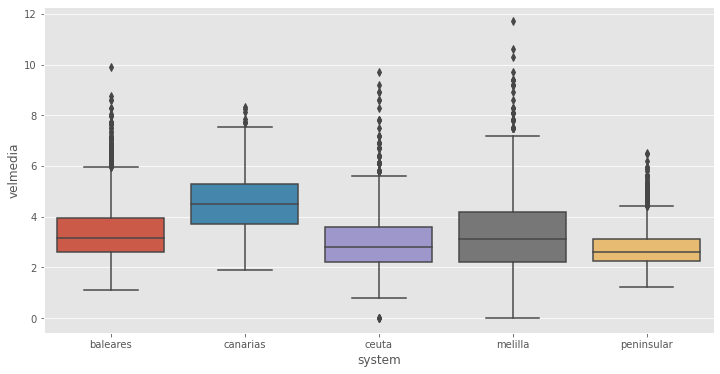

In [119]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='velmedia', data=df_weather_system);

In [120]:
df_weather_system['velmedia'].describe()

count    9840.000000
mean        3.391848
std         1.335338
min         0.000000
25%         2.463055
50%         3.100000
75%         4.200000
max        11.700000
Name: velmedia, dtype: float64

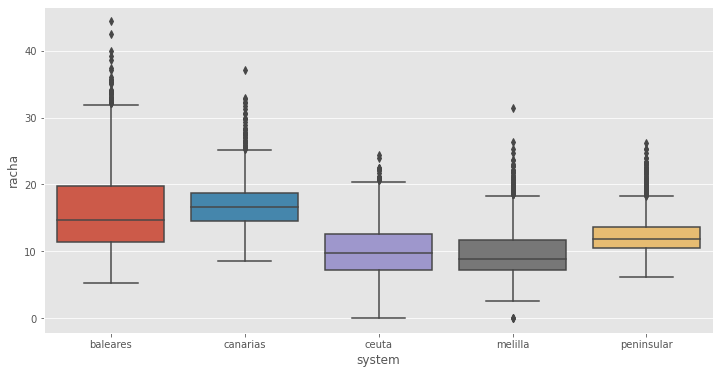

In [121]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='racha', data=df_weather_system);

In [122]:
df_weather_system['racha'].describe()

count    9840.000000
mean       13.009573
std         5.045018
min         0.000000
25%         9.518617
50%        12.200000
75%        16.011170
max        44.400000
Name: racha, dtype: float64

# Outliers

Vamos a buscar los outlier de precipitaciones y temperatura minima, por si fuesen datos erroneos.



### Outlier de Precipitaciones


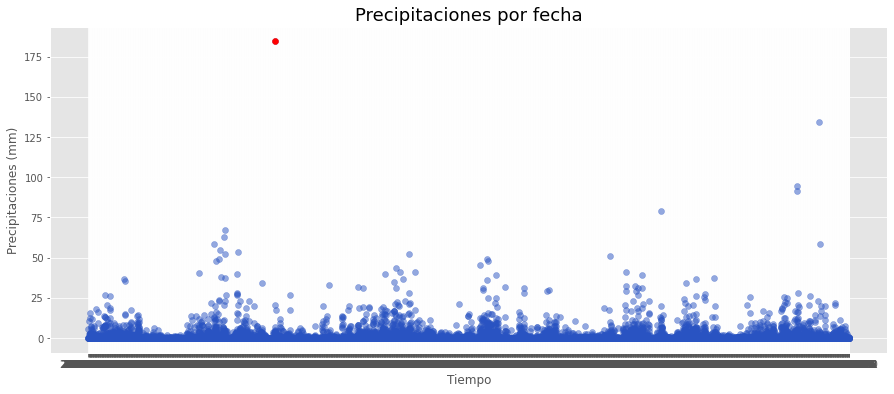

In [123]:

maxprec_mm=df_weather_system[df_weather_system['prec']==df_weather_system['prec'].max()]['prec']
maxprec_fec=df_weather_system[df_weather_system['prec']==df_weather_system['prec'].max()]['fecha']
plt.figure(figsize=(15,6))
plt.scatter(df_weather_system['fecha'],df_weather_system['prec'],c='#2953C2',alpha=0.5)
plt.scatter(maxprec_fec,maxprec_mm,c='r')
plt.title('Precipitaciones por fecha',fontsize=18)
plt.xlabel('Tiempo')
plt.ylabel('Precipitaciones (mm)')
plt.minorticks_off();


In [124]:
df_weather_system[df_weather_system['prec']==df_weather_system['prec'].max()]

,fecha,system,Holiday,weekday,tmin,presMin,prec,tmed,sol,velmedia,tmax,presMax,racha
2417,2017-04-28,ceuta,0,4,14.5,998.7,184.4,15.4,0.0,4.7,16.3,1002.7,11.9


### Outliers de Temperatura mínima

El 02-08-2020 tenemos un dato máximo en la serie histórica de temperaturas minimas de 31,8 grados en la estación de MELILLA

In [125]:
tminGrouped=df_weather_system.groupby('fecha')['tmin'].mean().reset_index()
maxtmin_celsius=df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].max()]['tmin']
maxtmin_fec=df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].max()]['fecha']
mintmin_celsius=df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].min()]['tmin']
mintmin_fec=df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].min()]['fecha']

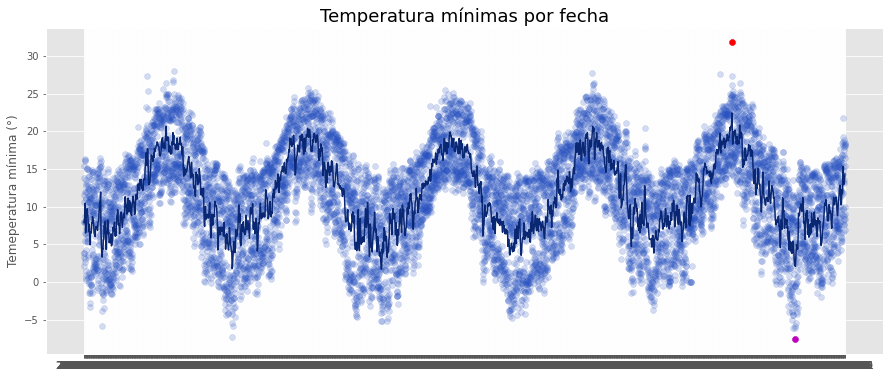

In [126]:

plt.figure(figsize=(15,6))
plt.plot(tminGrouped['fecha'],tminGrouped['tmin'],c='#0A2774')
plt.scatter(df_weather_system['fecha'],df_weather_system['tmin'],c='#2953C2',alpha=0.2)
plt.scatter(maxtmin_fec,maxtmin_celsius,c='r')
plt.scatter(mintmin_fec,mintmin_celsius,c='m')
plt.title('Temperatura mínimas por fecha',fontsize=18)
plt.ylabel('Tiempo')
plt.ylabel('Temeperatura mínima (°)');



In [127]:
df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].max()]

,fecha,system,Holiday,weekday,tmin,presMin,prec,tmed,sol,velmedia,tmax,presMax,racha
8378,2020-08-02,melilla,0,6,31.8,1005.7,0.0,35.4,12.1,4.7,39.1,1008.3,11.7


In [128]:
df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].min()]

,fecha,system,Holiday,weekday,tmin,presMin,prec,tmed,sol,velmedia,tmax,presMax,racha
9194,2021-01-12,peninsular,0,1,-7.570213,932.525532,0.022589,2.016294,7.020053,1.827664,10.544681,989.948936,8.670213


### Outliers de Temperatura máxima

In [129]:
tmaxGrouped=df_weather_system.groupby('fecha')['tmax'].mean().reset_index()
maxtmax_celsius=df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].max()]['tmax']
maxtmax_fec=df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].max()]['fecha']
mintmax_celsius=df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].min()]['tmax']
mintmax_fec=df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].min()]['fecha']

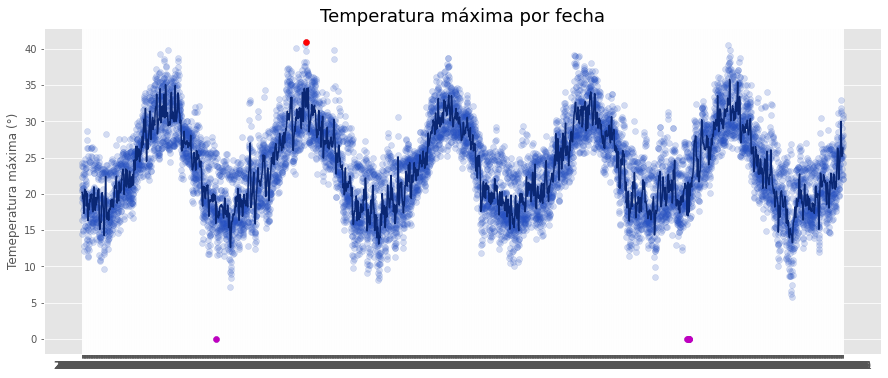

In [130]:
plt.figure(figsize=(15,6))
plt.plot(tmaxGrouped['fecha'],tmaxGrouped['tmax'],c='#0A2774')
plt.scatter(df_weather_system['fecha'],df_weather_system['tmax'],c='#2953C2',alpha=0.2)
plt.scatter(maxtmax_fec,maxtmax_celsius,c='r')
plt.scatter(mintmax_fec,mintmax_celsius,c='m')
plt.title('Temperatura máxima por fecha',fontsize=18)
plt.ylabel('Tiempo')
plt.ylabel('Temeperatura máxima (°)');


In [131]:
df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].max()]

,fecha,system,Holiday,weekday,tmin,presMin,prec,tmed,sol,velmedia,tmax,presMax,racha
2900,2017-08-03,baleares,0,3,21.0,1003.6,0.0,31.28,11.633333,2.77,40.9,1016.4,18.1


In [132]:
df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].min()]

,fecha,system,Holiday,weekday,tmin,presMin,prec,tmed,sol,velmedia,tmax,presMax,racha
1732,2016-12-12,ceuta,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7823,2020-04-13,melilla,0,0,0.0,1001.9,1.0,0.0,2.0,1.9,0.0,1005.6,6.4
7833,2020-04-15,melilla,0,2,0.0,1004.5,0.0,0.0,6.0,3.3,0.0,1011.8,8.1
7843,2020-04-17,melilla,0,4,0.0,1008.4,0.0,0.0,0.0,2.2,0.0,1010.8,6.1
7848,2020-04-18,melilla,0,5,0.0,1004.9,4.4,0.0,0.0,1.9,0.0,1009.1,5.3
7853,2020-04-19,melilla,0,6,0.0,1001.7,0.4,0.0,1.3,5.6,0.0,1006.2,16.1


#Save to pickle

In [133]:
df_weather_system.to_pickle(Ing_AEMET.path_Data+"Weather_df.pkl")

In [134]:
df_ree_filtered.to_pickle(Ing_AEMET.path_Data+"Ree_df.pkl")